## Mar 24, 2020

In [1]:
# import the necessary packages
from os import listdir
from os.path import isfile , join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage, signal, interpolate
from skimage import filters
import math
import sys

In [2]:
def rgb2gray(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

In [3]:
def circ_replicate(array): #repeat put last as first, and first as last again (circ)
    rows=len(array)
    try:
        columns=len(array[0])
        #print(rows)
        #print(columns)
        arr_replicated=np.tile(array,(3,3)) # copy one more column and one more row
        arr_replicated=arr_replicated[rows-1:2*rows+1, columns-1:2*columns+1]
    except: #1D vectors
        arr_replicated=np.tile(array,3) # copy one more column and one more row
        arr_replicated=arr_replicated[rows-1:2*rows+1] # truncate extraPlus rows 
    
    return arr_replicated

In [16]:
#print(circ_replicate([1,2,-3])) #1,len-2(b4 last) prev and next, #1,len-1(last) prev only, 
#print(circ_replicate([[1,2,-3],[0,2,3]]))#[len(circ_replicate([[1,2,-3],[0,2,3]]))-1,:])
print(circ_replicate([[1,2,-3],[0,2,3]])) #[x1, x2, x3], [y1, y2, y3]

[[ 3  0  2  3  0]
 [-3  1  2 -3  1]
 [ 3  0  2  3  0]
 [-3  1  2 -3  1]]


In [5]:
def get_4neighbors(pointsX, pointsY): #
    pointsOut= np.array([[pointsX, pointsY], [pointsX-1, pointsY], [pointsX+1, pointsY],\
                         [pointsX, pointsY-1], [pointsX, pointsY+1]    ] )
    return pointsOut

In [6]:
def gaussian_Filter(sigma, shape):
    filter=np.zeros(shape)
    filter[1,1]=1
    return ndimage.gaussian_filter(filter, sigma) 

In [7]:
def normalize(array, newMin, newMax):
    minArr=array.min()
    maxArr=array.max()
    return ((array-minArr)/(maxArr-minArr))*(newMax-newMin)+newMin

In [8]:
#print(get_4neighbors(2, 3))
#print(get_4neighbors(2, 3)[0,:])
#print(np.array([[1,2,4], [3,4,2]]))
#print(normalize(np.array([[1,2,-5], [-3,4,2]]), -1,0))
#print(normalize(np.array([[1,2,-5], [-3,4,2]]), 0, -1))
values = np.array([[  0.,   1.,   2.],
       [  3.,   4.,   5.],
       [  6.,   7.,   8.],
       [  9.,  10.,  11.]])

inds=np.array([[1, 2],  [0 ,2],  [2, 2],  [1 ,1],  [1, 3]])


print(inds)
print(np.transpose(inds))
print(ndimage.map_coordinates(values,np.transpose(inds)))
print(ndimage.map_coordinates(values, [[1],[2]]))

#print((np.array([2,3])).shape)
#np.array([[2,3], [1,3]])
#np.concatenate([[2,3], [1,3]],axis=0)

[[1 2]
 [0 2]
 [2 2]
 [1 1]
 [1 3]]
[[1 0 2 1 1]
 [2 2 2 1 3]]
[5. 2. 8. 4. 0.]
[5.]


In [9]:
images_files = [ join("./images" , f) for f in listdir("images") if isfile(join("images" , f)) ]
images = [ mpimg.imread( f ) for f in images_files ]
gray_images = [ rgb2gray( img ) for img in images ]

In [10]:
def compute_energy(pointsX, pointsY, alpha, beta, gamma, grad_normalized): #compute continuity energy
    #print(pointsX)
    #print(pointsY)
    newPointsX=np.zeros(pointsX.shape)
    newPointsY=np.zeros(pointsY.shape)
    grid_x, grid_y= np.mgrid[0:len(grad_normalized), 0:len(grad_normalized[0])]
    print(grid_x.shape)
    distance=0 #compute average distance 
    for ind in pointsX[1:len(pointsX)-1]: #range(len(pointsX)-2)=Equivalent:  
        distance+=np.sqrt((pointsX[ind]-pointsX[ind+1]) ** 2+(pointsY[ind]-pointsY[ind+1]) ** 2)
    
    distance/=(len(pointsX)-2) # average contour distance 
    
    for ind in pointsX[1:len(pointsX)-1]: #compute elastic energy VECTOR #cover all Core points
        # having circular previous and circ next
        #print(pointsX[ind])        
        #if False: #block comment
        elas_En=np.zeros(5) # For the Current contour point and its 4-neighbors
        curv_En=np.zeros(5) # For the Current contour point and its 4-neighbors
        Grad_En=np.zeros(5) # For the Current contour point and its 4-neighbors
        
        allpoints_4=get_4neighbors(pointsX[ind],pointsY[ind]) # retrieve neighbors
        #print(allpoints_4)
        Grad_En =  ndimage.map_coordinates(grad_normalized, np.transpose(allpoints_4))#spline
        for neigh in range(len(allpoints_4)): #cover all neighbors           
            elas_En[neigh]=distance-(np.sqrt((allpoints_4[neigh,0]-pointsX[ind-1]) ** 2+\
                                (allpoints_4[neigh,1]-pointsY[ind-1]) ** 2)) #neighbors
            #print(allpoints_4[neigh,0],allpoints_4[neigh,1],pointsX[ind-1],pointsY[ind-1],\
            #     pointsX[ind+1],pointsY[ind+1])
            #print(elas_En)
            curv_En[neigh]=np.sqrt((2*allpoints_4[neigh,0]-pointsX[ind+1]-pointsX[ind-1]) **2 +\
                        (2*allpoints_4[neigh,1]-pointsY[ind+1]-pointsY[ind-1]) **2)            
            
        elas_En=alpha*elas_En
        curv_En=beta*curv_En
        Grad_En=gamma*Grad_En

        total_En=elas_En+curv_En+Grad_En
        indMin=np.argmin(total_En)
        print(pointsX[ind], pointsY[ind])
        newPointsX[ind]=allpoints_4[indMin,0]
        newPointsY[ind]=allpoints_4[indMin,1]
        
        print(pointsX[ind], pointsY[ind])
        print(newPointsX[ind], newPointsY[ind])

        print(allpoints_4)
        print(total_En) 
        print(indMin)
        #print(len(grad_normalized))        
        
        #print('\n')
    #print(distance)
    return newPointsX, newPointsY


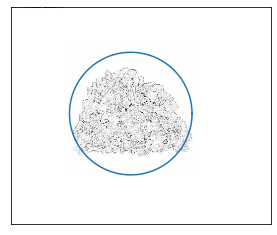

(816, 976)
1 2
1 2
1.0 3.0
[[1 2]
 [0 2]
 [2 2]
 [1 1]
 [1 3]]
[2.92181747 3.80390436 2.35459718 3.80353668 2.35370662]
4
2 3
2 3
2.0 3.0
[[2 3]
 [1 3]
 [3 3]
 [2 2]
 [2 4]]
[0.23570226 2.04191848 1.42477505 2.04280904 1.42477505]
0
3 4
3 4
2.0 4.0
[[3 4]
 [2 4]
 [4 4]
 [3 3]
 [3 5]]
[3.62981481 2.97263117 4.48953657 2.97263117 4.48953657]
1


In [11]:
img=gray_images[1];
img_gFilter=signal.convolve2d(img, gaussian_Filter(0.3, (3,3)), mode='same')
img_gradX=ndimage.sobel(img_gFilter,axis=0)
img_gradY=ndimage.sobel(img_gFilter,axis=1)
img_grad=np.hypot(img_gradX,img_gradY)
img_grad_norm=-normalize(img_grad,0,1)# Normalization
#print(img_grad)
#print(img_grad_norm)

r=230 #radius
c=[450,400] #center
theta=np.linspace(0, 2*np.pi, 200) # min, max, number of divisions
x=c[0]+r*np.cos(theta)
y=c[1]+r*np.sin(theta)
plt.plot(x,y)
plt.figure(1),plt.imshow(img_grad_norm, cmap='gray')
plt.xticks([]), plt.yticks([])# hides the tick values on main axes
ax=plt.gca()
ax.contour((x,y)) #plots contours
plt.show()

##np.concatenate((np.transpose(x), np.transpose(y)))## ??
iniContour=np.array(list(zip(x,y)))## 
#print(iniContour.shape)
arr=np.array([[1, 2], [3, 4],[-3, 14]])
#print(type(x))

x_rep=circ_replicate([1, 2,3]) # circular repeat
y_rep=circ_replicate([2,3,4]) # circular repeat
#elastic_energy((1,2,3,1),(2,3,4,2)) #1.4+1.4+2.8=2.8*2=5.6, avg=1.8856
newContour=compute_energy(x_rep,y_rep, 0.5, 0.8, 0.4,img_grad_norm) #1.4+1.4+2.8=2.8*2=5.6, avg=1.8856


In [ ]:
def CV (contour, img, mu, nu, epison,step):

    Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
    Hea = 0.5*(1 + (2 / math.pi)*mat_math(contour/epison,"atan")) 
    Iy, Ix = np.gradient(LSF) 
    s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
    Nx = Ix / (s+0.000001) 
    Ny = Iy / (s+0.000001) 
    Mxx,Nxx =np.gradient(Nx) 
    Nyy,Myy =np.gradient(Ny) 
    cur = Nxx + Nyy 
    Length = nu*Drc*cur 

    Lap = cv2.Laplacian(LSF,-1) 
    Penalty = mu*(Lap - cur) 

    s1=Hea*img 
    s2=(1-Hea)*img 
    s3=1-Hea 
    C1 = s1.sum()/ Hea.sum() 
    C2 = s2.sum()/ s3.sum() 
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

    LSF = LSF + step*(Length + Penalty + CVterm) 
    #plt.imshow(s, cmap ='gray'),plt.show() 
    return LSF 

In [ ]:
mu = 1 
nu = 0.003 * 255 * 255 
num = 20 
epison = 1 
step = 0.1 
LSF=IniLSF 
for i in range(1,num):
    LSF = CV(LSF, img, mu, nu, epison,step) 
    if i % 1 == 0:
        plt.imshow(Image),plt.xticks([]), plt.yticks([])  
        plt.contour(LSF,[0],colors='r',linewidth=2) 
        plt.draw(),plt.show(block=False),plt.pause(0.01) 

In [ ]:
def multi_view( images ):
    images_count = len( images ) #count of images (list type)
    fig = plt.figure(figsize=(10,20))
    for row in range( images_count  ):
        ax1 = fig.add_subplot( images_count , 1 , row + 1)
        #ax1.imshow( images[ row ] )
        ax1.imshow(images[ row ], cmap=plt.get_cmap('gray')) # default is viridis 

In [ ]:
dft_images=[np.fft.fft2(img) for img in gray_images] #2D fft
dft_images_shifted=[np.fft.fft2(img) for img in dft_images] # shifted 2D fft

#magnitude_spectrum = [np.log(np.abs(fshift+1)) for fshift in dft_images_shifted]
dft_Mag= [np.sqrt(img.real**2 + img.imag**2) for img in dft_images_shifted]
#dft_Phase= [np.arctan(img.imag/img.real) for img in magnitude_spectrum]
magnitude_spectrum = [np.log(np.abs(fshift+1)) for fshift in dft_Mag]

combinations=list(zip(gray_images,dft_Mag))
[multi_view(setImg) for setImg in combinations]
